# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO

from matplotlib import pyplot as plt
from PIL import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2

In [2]:
%matplotlib inline

## Env setup

In [21]:
sys.path.append("..")

## Object detection imports
Here are the imports from the object detection module.

In [4]:
from utils import label_map_util
 
from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  


In [5]:
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'

PATH_TO_CKPT = 'frozen_inference_graph.pb'

PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Function to Load a (frozen) Tensorflow model into memory 

In [6]:
def load_detection_model(PATH_TO_CKPT=PATH_TO_CKPT):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph


## Function to convert image into numpy array

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## Function to Process image

In [8]:
def detection_operations():
    with detection_graph.as_default():
        with tf.compat.v1.Session(graph=detection_graph) as sess:
            # Definite input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    return image_tensor, detection_boxes, detection_scores, detection_classes, num_detections

In [ ]:
def process_image(image):
    with detection_graph.as_default():
        with tf.compat.v1.Session(graph=detection_graph) as sess:
           
            image = cv2.resize(image, (800,450))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_np_expanded = np.expand_dims(image, axis=0)
            # Actual detection.
            (boxes, scores, classes, num) = sess.run([detection_boxes, detection_scores, detection_classes, num_detections],feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            image_copy = np.copy(image)

            vis_util.visualize_boxes_and_labels_on_image_array(image_copy, np.squeeze(boxes), np.squeeze(classes).astype(np.int32),np.squeeze(scores),category_index,use_normalized_coordinates=True,line_thickness=8)
            for i,b in enumerate(boxes[0]):
                #                 car                    bus                  truck
                if classes[0][i] == 3 or classes[0][i] == 6 or classes[0][i] == 8:
                    if scores[0][i] >= 0.5:
                        mid_x = (boxes[0][i][1]+boxes[0][i][3])/2
                        mid_y = (boxes[0][i][0]+boxes[0][i][2])/2
                        apx_distance = round(((1 - (boxes[0][i][3] - boxes[0][i][1]))**4),1)
                        
                        if mid_x > 0.3 and mid_x < 0.7:
                            
                            #for car
                            if classes[0][i] == 3:
                                if apx_distance <=0.5:
                                    cv2.putText(image_copy, 'WARNING!!!', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,255), 3)

                            #for bus
                            if classes[0][i] == 6:
                                if apx_distance <=0.4:
                                    cv2.putText(image_copy, 'WARNING!!!', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,255), 3)
                             #for truck
                            if classes[0][i] == 8:
                                if apx_distance <=0.3:
                                    cv2.putText(image_copy, 'WARNING!!!', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,255), 3)

            return image_copy            

In [18]:
def clear_cache():
    process_image.cache = None

## Loading label map and load model

In [11]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [12]:
detection_graph = load_detection_model()
image_tensor, detection_boxes, detection_scores, detection_classes, num_detections = detection_operations()

# Detection in vedio

In [27]:
write_output = 'project_video_2.mp4'
#start_second and end_second
#clip1 = VideoFileClip("project_video.mp4").subclip(0,3)
clip1 = VideoFileClip("sample_1.MOV")
#clear_cache()
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(write_output, audio=False)

t:   0%|                                                                            | 0/1824 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video.mp4.
Moviepy - Writing video project_video.mp4




t:   4%|██▍                                                              | 67/1824 [04:14<1:22:14,  2.81s/it, now=None]


t:   7%|████▋                                                           | 133/1824 [07:09<1:11:13,  2.53s/it, now=None]


t:  11%|██████▉                                                         | 199/1824 [09:53<1:06:51,  2.47s/it, now=None]


t:  15%|█████████▎                                                      | 265/1824 [13:10<1:16:09,  2.93s/it, now=None]


t:  18%|███████████▌                                                    | 331/1824 [16:19<1:15:02,  3.02s/it, now=None]


t:  22%|█████████████▉                                                  | 397/1824 [19:26<1:06:05,  2.78s/it, now=None]


t:  25%|████████████████▊                                                 | 463/1824 [22:20<57:12,  2.52s/it, now=None]


t:  29%|███████████████████▏                                              | 529/1824 [25:05<54:05,  2.51s/it, now=None]


t:  33%|█████████████████████▌                                            | 595/1824 [27:50<51:18,  2.50s/it, now=None]


t:  36%|███████████████████████▉                                          | 661/1824 [30:40<48:40,  2.51s/it, now=None]


t:  40%|██████████████████████████▎                                       | 727/1824 [33:32<48:22,  2.65s/it, now=None]


t:  43%|████████████████████████████▋                                     | 793/1824 [36:22<44:05,  2.57s/it, now=None]


t:  47%|███████████████████████████████                                   | 859/1824 [39:10<40:49,  2.54s/it, now=None]


t:  51%|█████████████████████████████████▍                                | 925/1824 [42:01<42:19,  2.83s/it, now=None]


t:  54%|███████████████████████████████████▊                              | 991/1824 [45:09<37:09,  2.68s/it, now=None]


t:  58%|█████████████████████████████████████▋                           | 1057/1824 [48:08<37:41,  2.95s/it, now=None]


t:  62%|████████████████████████████████████████                         | 1123/1824 [51:19<32:57,  2.82s/it, now=None]


t:  65%|██████████████████████████████████████████▎                      | 1189/1824 [55:13<54:42,  5.17s/it, now=None]


t:  69%|███████████████████████████████████████████▎                   | 1255/1824 [1:00:48<47:42,  5.03s/it, now=None]


t:  72%|█████████████████████████████████████████████▋                 | 1321/1824 [1:06:23<42:45,  5.10s/it, now=None]


t:  76%|███████████████████████████████████████████████▉               | 1387/1824 [1:11:58<37:10,  5.10s/it, now=None]


t:  80%|██████████████████████████████████████████████████▏            | 1453/1824 [1:17:32<31:43,  5.13s/it, now=None]


t:  83%|████████████████████████████████████████████████████▍          | 1519/1824 [1:23:59<29:47,  5.86s/it, now=None]


t:  87%|██████████████████████████████████████████████████████▋        | 1585/1824 [1:30:35<20:22,  5.12s/it, now=None]


t:  91%|█████████████████████████████████████████████████████████      | 1651/1824 [1:36:18<14:57,  5.19s/it, now=None]


t:  94%|███████████████████████████████████████████████████████████▎   | 1717/1824 [1:42:21<09:16,  5.20s/it, now=None]


t:  98%|█████████████████████████████████████████████████████████████▌ | 1783/1824 [1:48:04<03:30,  5.15s/it, now=None]


t:   7%|████▍                                                             | 34/501 [2:42:59<43:35,  5.60s/it, now=None]

Moviepy - Done !
Moviepy - video ready project_video.mp4
Wall time: 1h 51min 47s


## Detection in image

In [23]:

PATH_TO_TEST_IMAGES_DIR = 'test_car_images'
TEST_IMAGE_PATHS = ['1.jpg', '2.jpg','3.jpeg']


IMAGE_SIZE = (12, 8)

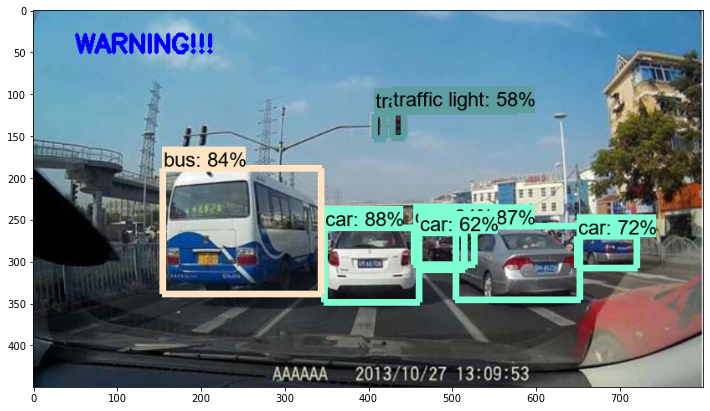

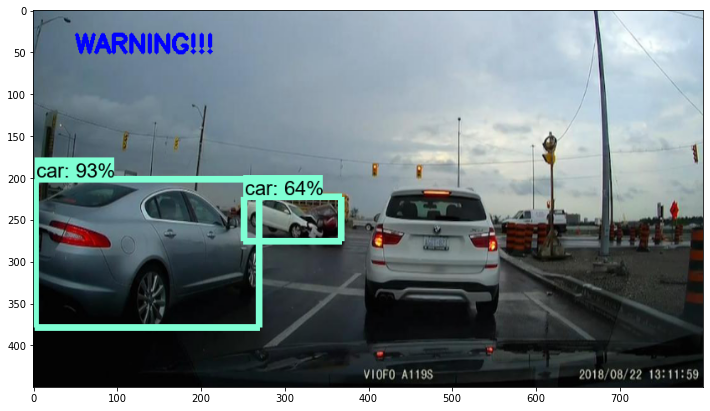

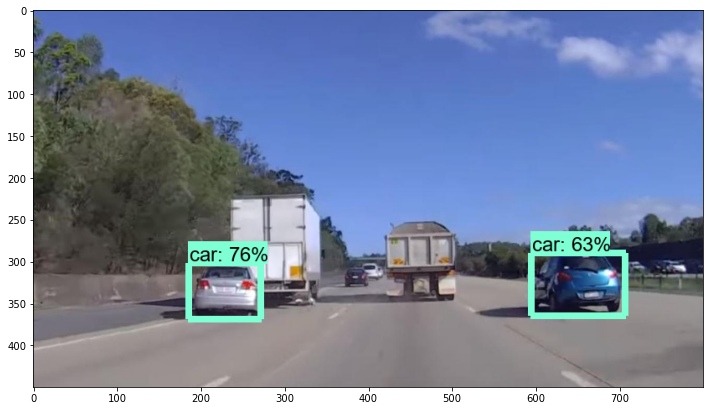

In [24]:
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    image_processed=process_image(image_np)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_processed)
    plt.show()

In [15]:
%matplotlib inline